## Steenbras Dam, South Africa

**Station Name:** sbas

**Latitude:** -34.18704704

**Longitude:** 18.84986166

**Ellipsoidal Height(m):** 403.342

**Network:** TRIGNET

**Archive:** UNAVCO (use the special option)

<img src=https://gnss-reflections.org/static/images/SBAS.jpg width=500>


The data used here have been kindly provided by TRIGNET so that we could access L1 and L2C signals 
at 15 second sampling. This sampling rate is needed to be able to see the reservoir. However, they are in a proprietary Trimble binary format.  
It is non-trivial to convert those to RINEX, so in this example we will rely on files translated and 
archived by UNAVCO for this use case example. They can be used by specifying the "special" archive.
Here we will only discuss GPS - I would encourage you to also look at the Glonass data.

In [1]:
import ipywidgets as widgets
import os

from pathlib import Path

from gnssrefl.utils import check_environment, set_environment, get_sys

notebook_dir = Path.cwd().parents[1]

# Making sure environment variables are set - this is required to run the gnssrefl code
exists = check_environment()
if exists == False:
    set_environment(refl_code=str(notebook_dir),
                    orbits=str(notebook_dir / "orbits"),
                    exe=str(notebook_dir / "exe"))
    
#If you are running this locally - make sure the items in the exe folder have execution permissions

# Set local variable of refl_code location
refl_code_loc = os.environ['REFL_CODE']
print("refl_code location:", refl_code_loc)

# import gnssrefl functions
from gnssrefl.installexe_cl import installexe
from gnssrefl.rinex2snr_cl import rinex2snr
from gnssrefl.quickLook_cl import quicklook
from gnssrefl.gnssir_cl import gnssir
from gnssrefl.gnssir_input import make_gnssir_input
from gnssrefl.daily_avg_cl import daily_avg


# import the crx2rnx file which is dependent on your working OS - this is required to run the gnssrefl code
# If in docker environment, then you do not need to download crxnrnx
try:
    os.environ['DOCKER']
except KeyError:
    sys = get_sys()
    installexe(sys)

environment variable ORBITS set to path /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/orbits 
environment variable REFL_CODE set to path /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks 
environment variable EXE set to path /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/exe
refl_code location: /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks
Your executable environment area:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/exe
There is no teqc executable for this architecture, so none will be installed.
This Hatanaka executable already exists
The gfzrnx executable already exists


**Fast Mode:** 
this will download data weekly instead of daily

In [2]:
weekly = widgets.Checkbox(value=True, description='Fast Mode', disabled=False, indent=False)
weekly

Checkbox(value=True, description='Fast Mode', indent=False)

Deselect the Fast Mode checkbox to deactivate fast mode.

### Reflection Zones 

Use the [reflection zone web app](https://gnss-reflections.org/rzones) to think about which azimuths and elevation angles to use.
Note the photograph!  **You are not 6 meters (vertically) above the water.** You will not be able to fully test
the reflector height value used in this web app until you look at some real data. But you can get an idea of which
RH values put you over the water.

### Evaluate the Data

We know that the reservoir will only be in the northeast quadrant, so I am going 
to select those azimuths specifically. I will start with elevation angle limits of 5-12 degrees and the superior L2C frequency.

In [3]:
station = 'sbas'

rinex2snr(station, 2020, 1, archive='special')

sbas  year: 2020  doy: 1 from:  special
Requested a GPS only nav file
Nav file exists online
Orbit file:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/orbits/2020/nav/auto0010.20n
Seeking permission from Earthscope to use their archive


SUCCESS: SNR file was created 
 /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/2020/snr/sbas/sbas0010.20.snr66
That took  1.18  seconds
Feedback written to subdirectory logs


Lets try different heights:

minimum elevation angle (degrees) for this dataset:  4.8968
plot saved to  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/sbas/quickLook_lsp.png
plot saved to  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/sbas/quickLook_summary.png


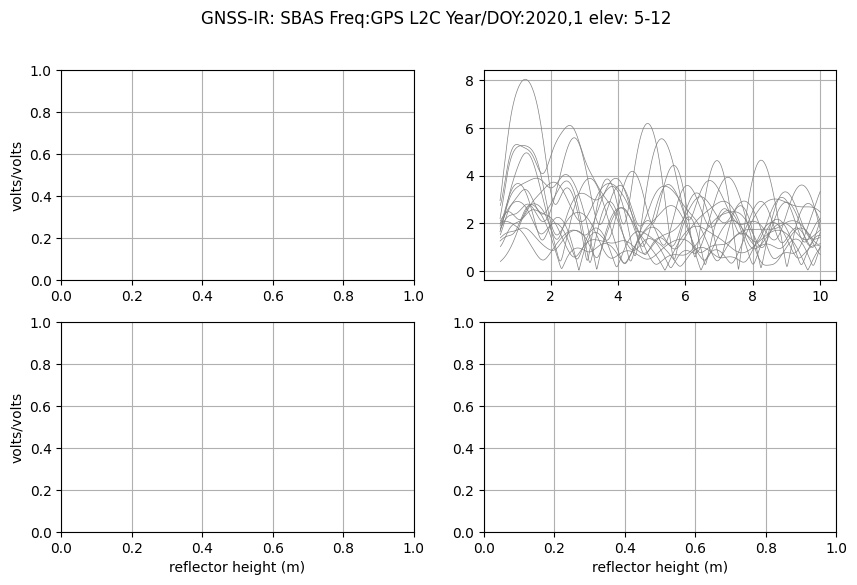

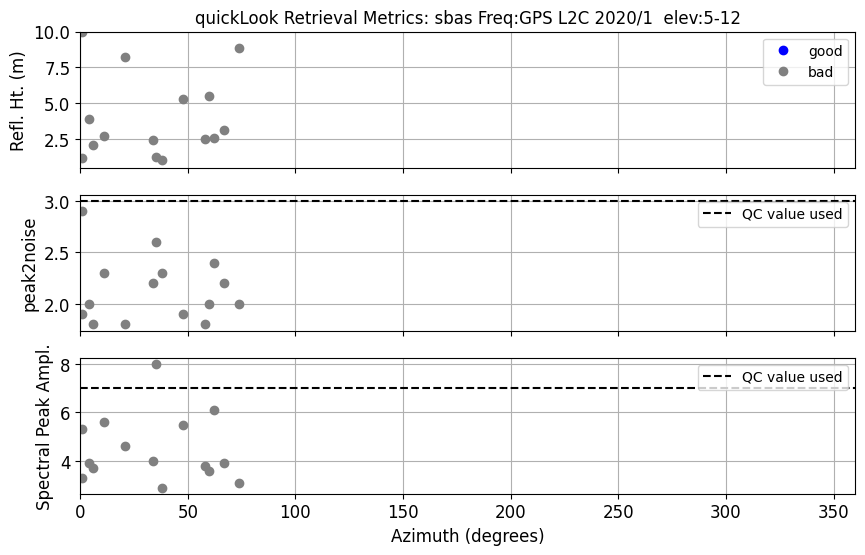

In [4]:
vals, metrics = quicklook(station, 2020, 1, e2=12, h1=.5, h2=10, azim1=0, azim2=75, fr=20)

minimum elevation angle (degrees) for this dataset:  4.8968
plot saved to  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/sbas/quickLook_lsp.png
plot saved to  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/sbas/quickLook_summary.png


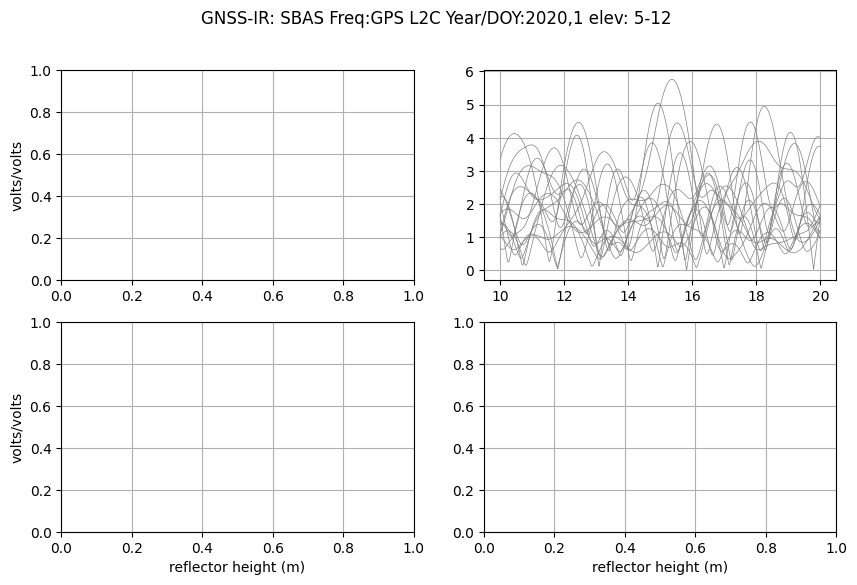

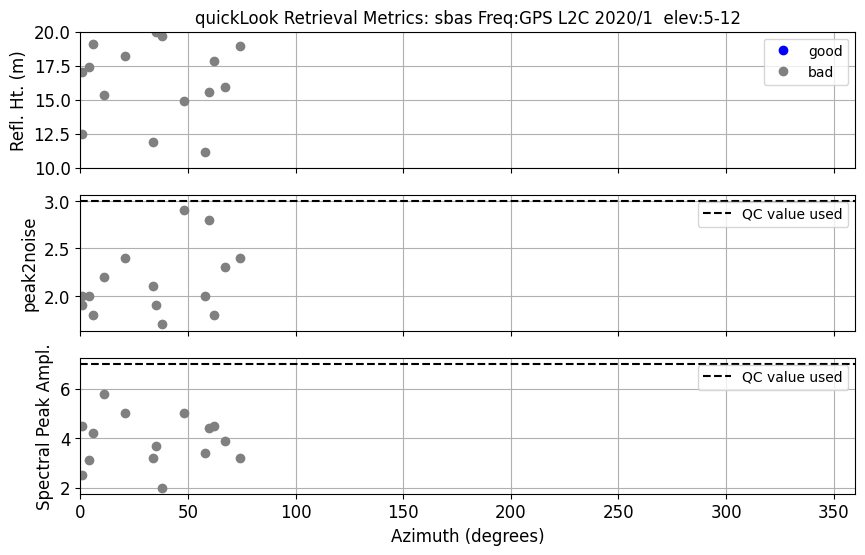

In [5]:
vals, metrics = quicklook(station, 2020, 1, e2=12, h1=10, h2=20, azim1=0, azim2=75, fr=20)

minimum elevation angle (degrees) for this dataset:  4.8968
plot saved to  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/sbas/quickLook_lsp.png
plot saved to  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/sbas/quickLook_summary.png


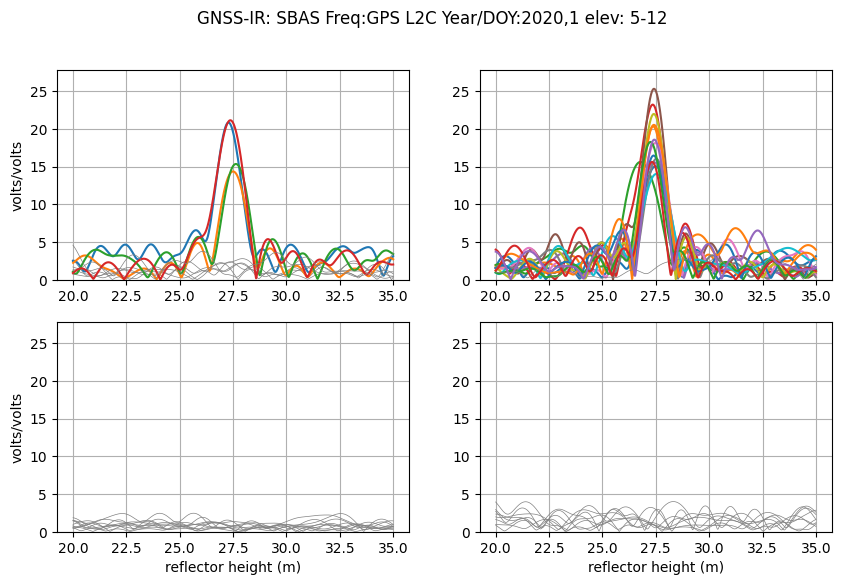

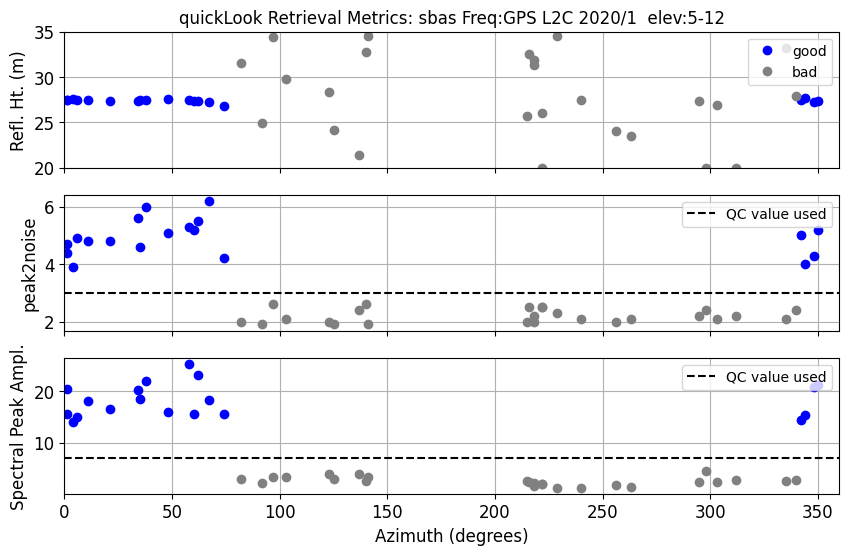

In [6]:
vals, metrics = quicklook(station, 2020, 1, e2=12, h1=20, h2=35, fr=20)

You can add the screenstats parameter to get more details about the plot values.

Some screen statistics will print to the screen
minimum elevation angle (degrees) for this dataset:  4.8968
Keep   sat/arc 1 1 0 185  min/max elev:  5.11 10.51
Keep   sat/arc 1 2 186 434  min/max elev:  5.28 29.87
Failed sat/arc 1 3 435 677  min/max elev:  7.55 29.94  violates ediff
Keep   sat/arc 1 3 677 878  min/max elev:  6.24 10.85
Failed sat/arc 1 4 878 949  min/max elev:  10.3 10.85  violates ediff
SUCCESS for Azimu   6.8 Satellite  1 UTC  5.96 RH  27.490 PkNoise   4.94
Keep   sat/arc 3 1 0 325  min/max elev:  6.46 29.98
Keep   sat/arc 3 2 325 698  min/max elev:  6.26 30.0
Keep   sat/arc 3 3 698 1023  min/max elev:  5.22 29.94
Keep   sat/arc 3 4 1023 1290  min/max elev:  6.54 29.97
SUCCESS for Azimu  34.5 Satellite  3 UTC  8.60 RH  27.380 PkNoise   5.64
Failed sat/arc 5 1 0 219  min/max elev:  7.13 29.91  violates ediff
Keep   sat/arc 5 1 219 574  min/max elev:  5.04 29.97
SUCCESS for Azimu  74.4 Satellite  5 UTC 19.64 RH  26.780 PkNoise   4.18
Failed sat/arc 6 1 0 216  min/max e

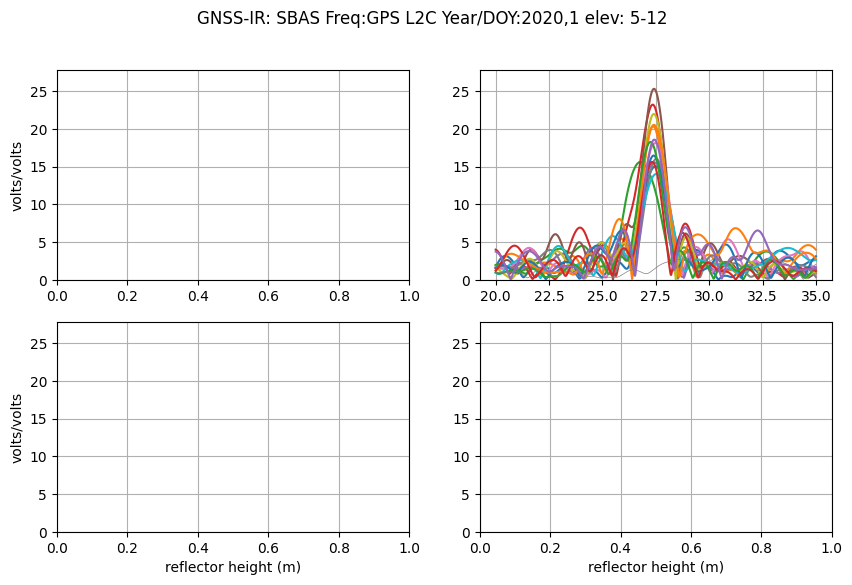

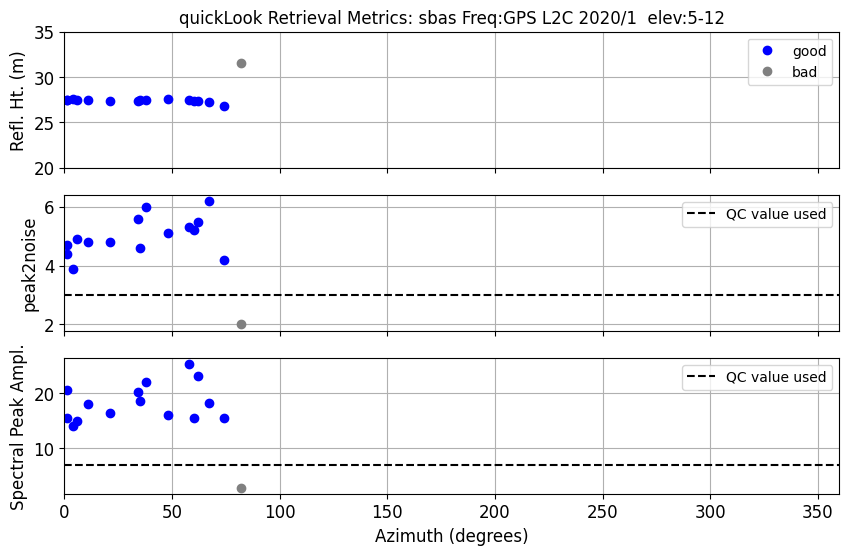

In [7]:
vals, metrics = quicklook(station, 2020, 1, e2=12, h1=20, h2=35, azim1=0, azim2=90, fr=20, screenstats=True)

Looks like satellite 5 at an azimuth of 78.4 degrees is the problem, so we 
will further restrict our analysis to 78 degrees in the next section.

You might go back and use the reflection zone web app to make sure that your azimuth and 
elevation angles look good for a RH of 28 meters.


### Estimate Lake Level

Make the SNR files:

In [8]:
rinex2snr(station, 2020, 1, doy_end=366, archive='special', weekly=weekly.value)

You have invoked the weekly option
SNR file already exists /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/2020/snr/sbas/sbas0010.20.snr66
sbas  year: 2020  doy: 8 from:  special
Requested a GPS only nav file
100% [..............................................................................] 75395 / 75395found nav file at SOPAC
Orbit file:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/orbits/2020/nav/auto0080.20n
Seeking permission from Earthscope to use their archive


SUCCESS: SNR file was created 
 /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/2020/snr/sbas/sbas0080.20.snr66
sbas  year: 2020  doy: 15 from:  special
Requested a GPS only nav file
100% [..............................................................................] 75733 / 75733found nav file at SOPAC
Orbit file:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/orbits/2020/nav/auto0150.20n
Seeking permission from Earthscope to use their archive


SUCCESS: SNR file was created 
 /Users/kellyenloe/

Save your analysis strategy. restrict azimuths to 0-78 degrees.

In [10]:
make_gnssir_input(station, e2=12, h1=20, h2=35, peak2noise=3, ampl=10, azlist2=[0,78])

Assume you want to use the UNR database.
Using standard frequency choices.
writing out to: /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/input/sbas.json


Hand edit the json file to restrict azimuths to 0-78 degrees and include 340-360.


The next step is to estimate reflector heights. First do a single day using the plt option.

{'station': 'sbas', 'lat': -34.187047043, 'lon': 18.849861655999973, 'ht': 403.3415279, 'minH': 20, 'maxH': 35, 'e1': 5.0, 'e2': 12, 'NReg': [20, 35], 'PkNoise': 3, 'polyV': 4, 'pele': [5, 30], 'ediff': 2.0, 'desiredP': 0.005, 'azval2': [0, 360], 'freqs': [1, 20, 5], 'reqAmp': [10, 10, 10], 'refraction': True, 'overwriteResults': True, 'seekRinex': False, 'wantCompression': False, 'plt_screen': False, 'onesat': None, 'screenstats': False, 'pltname': 'sbas_lsp.png', 'delTmax': 75.0, 'gzip': False, 'ellist': []}
refraction file exists
requested frequencies  [1, 20, 5]
Using the New Way of Selecting Arcs
Augmented elevation angle list []
Requested azimuths:  [0, 360]
Using azimuths:  [0, 360]
Refraction parameters  973.9207231538362 15.677599838231313 1
Using:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/2020/snr/sbas/sbas0010.20.snr66
Results will be written to: /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/2020/results/sbas//001.txt
data found for this frequency:  1


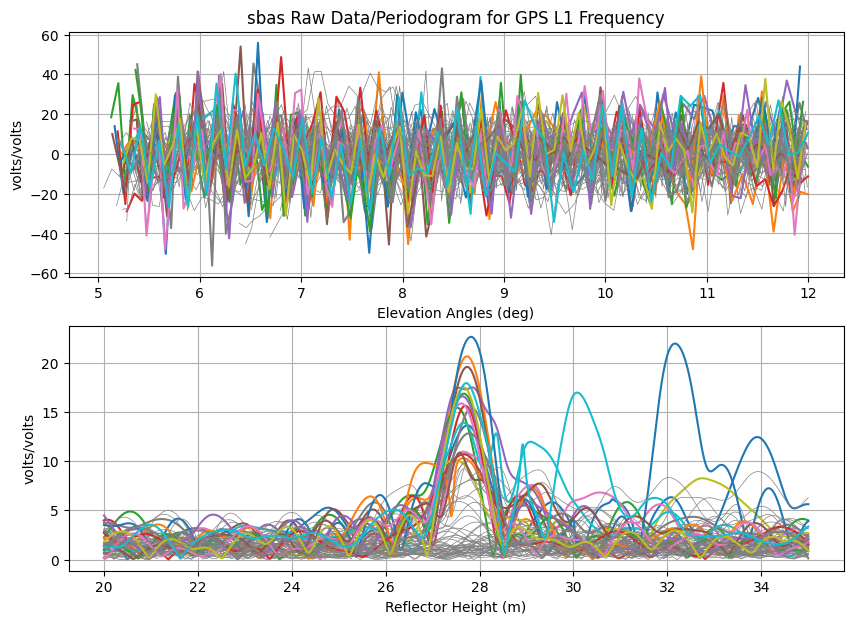

data found for this frequency:  20


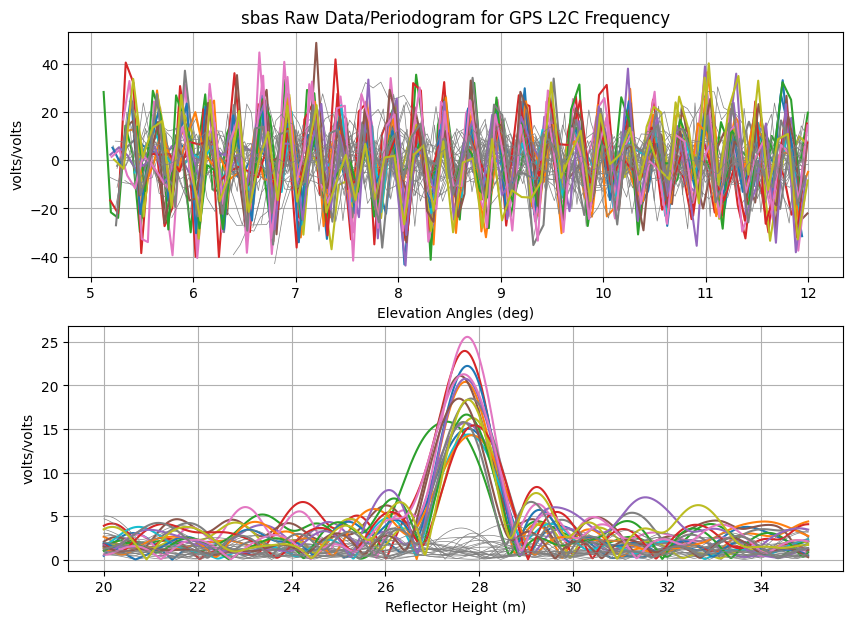

data found for this frequency:  5


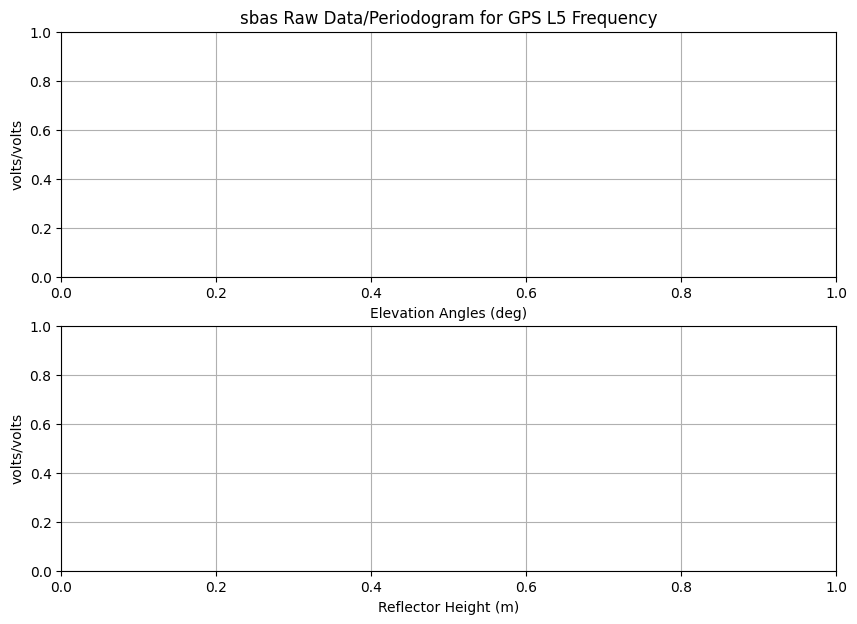

In [12]:
gnssir('sbas', 2020, 1, plt=True)

For the L1 frequecy reflector height plot - you can see what happens if you violate the Nyquist - double peaks!

Luckily this is not prevalent in this dataset thanks to the help of TRIGNET 
using a 15 second sample rate in the files.

You'll notice that the L2C frequency - which has a longer wavelength than L1 - does not have a double peak.
And that is what we should expect.

Go ahead and estimate reflector heights for all available days:

In [13]:
gnssir(station, 2020, 1, doy_end=365)

{'station': 'sbas', 'lat': -34.187047043, 'lon': 18.849861655999973, 'ht': 403.3415279, 'minH': 20, 'maxH': 35, 'e1': 5.0, 'e2': 12, 'NReg': [20, 35], 'PkNoise': 3, 'polyV': 4, 'pele': [5, 30], 'ediff': 2.0, 'desiredP': 0.005, 'azval2': [0, 360], 'freqs': [1, 20, 5], 'reqAmp': [10, 10, 10], 'refraction': True, 'overwriteResults': True, 'seekRinex': False, 'wantCompression': False, 'plt_screen': False, 'onesat': None, 'screenstats': False, 'pltname': 'sbas_lsp.png', 'delTmax': 75.0, 'gzip': False, 'ellist': []}
refraction file exists
requested frequencies  [1, 20, 5]
Using the New Way of Selecting Arcs
Augmented elevation angle list []
Requested azimuths:  [0, 360]
Using azimuths:  [0, 360]
Refraction parameters  973.9207231538362 15.677599838231313 1
Using:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/2020/snr/sbas/sbas0010.20.snr66
Results will be written to: /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/2020/results/sbas//001.txt
Using the New Way of Selecting Arcs
Augm

Compute a daily average. Since we only have reflections in one geographic quadrant and are 
only using GPS signals, we should not require as many points as we have done in other examples. 
I am going to start by requiring 10:

All RH retrievals - including bad ones - will be written to: 
/Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/sbas/sbas_allRH.txt.noqc 

All RH retrievals that meet your median filter and ReqTracks criteria will be written to: 
/Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/sbas/sbas_allRH.txt 

A total of  45  days were evaluated.
0  days did not meet the threshold set for a dependable daily average
All RH png file saved as:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/sbas/sbas_AllRH.png
All RH png file without QC saved as:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/sbas/sbas_AllRH_noQC.png
Daily average RH png file saved as:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/sbas/sbas_RH.png
Daily average RH amplitude file saved as:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/sbas/sbas_RHamp.png
Number of values used in average RH file saved as:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/sbas/s

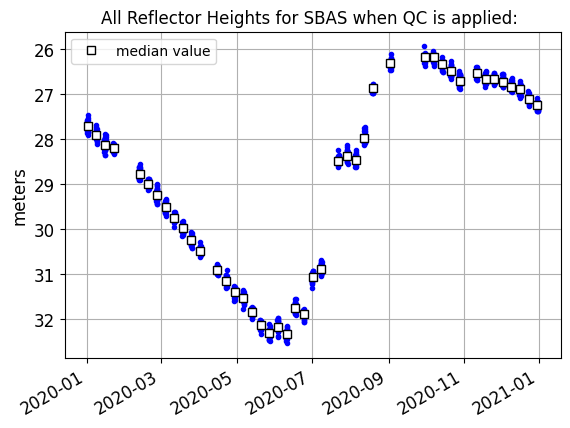

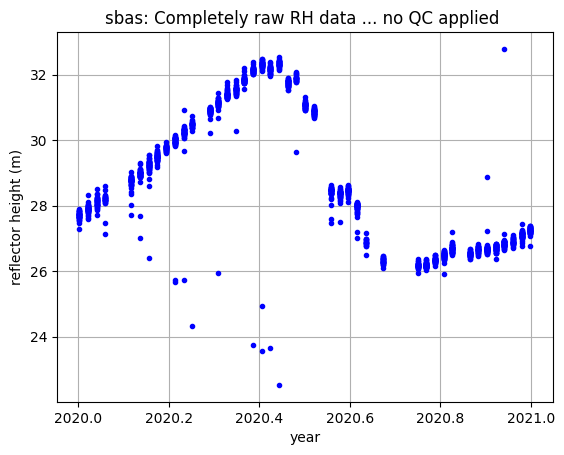

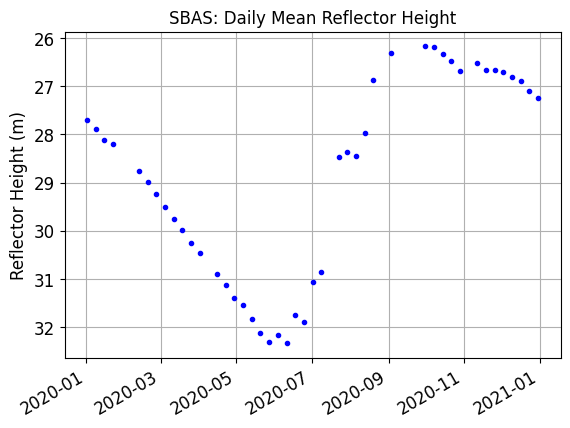

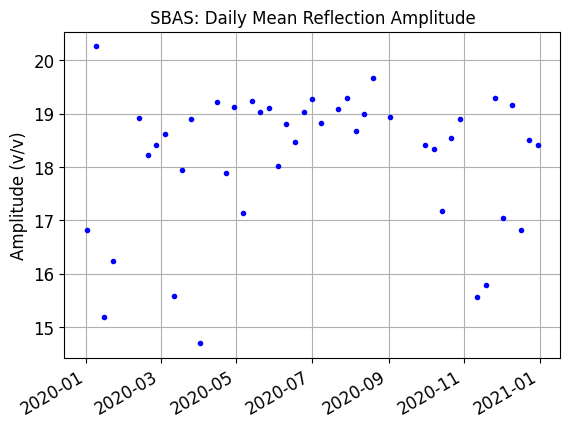

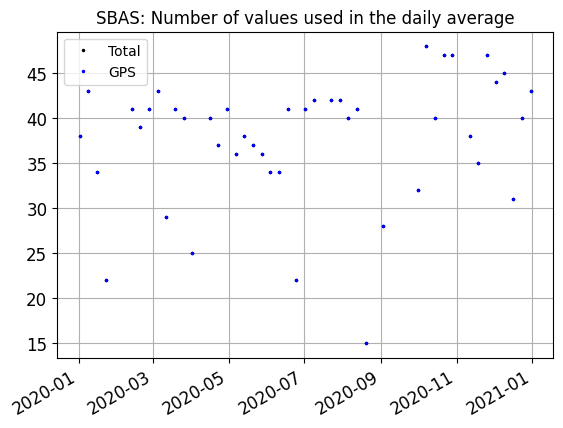


Daily average RH file written to:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/sbas/sbas_dailyRH.txt


In [14]:
daily_avg(station, 0.25, 10)

Note the missing points - this has nothing to do with reflectometry. These are days when the station did not report data.
Numerical values are saved in a file. The location of the file is printed to the screen.

You should also go back and add some of those very northwestern tracks by setting a second azimuth region in your json file.
Then rerun the <code>gnssir</code> and <code>daily_avg</code> codes.

### Compare with in situ data:

[Current state of the lower Steenbras reservoir](https://www.dws.gov.za/Hydrology/Weekly/percentile.aspx?station=%20G4R001)

[This is a link for all reservoirs](https://www.dws.gov.za/Hydrology/Weekly/ProvinceWeek.aspx?region=WC)

Simon Williams found this web app that will [provide 2020 data for a comparison](https://www.dws.gov.za/Hydrology/Verified/HyData.aspx?Station=G4R001100.00&DataType=Point&StartDT=2020-01-01&EndDT=2020-12-31&SiteType=RES)

As a final remark, there are lots of lake/reservoir/river gauges around the world. The beauty of using this GPS dataset to measure 
the reservoir level is that you can combine these RH values with the [height estimates from "normal" GPS](http://geodesy.unr.edu/NGLStationPages/stations/SBAS.sta).
This means your reservoir measurements are in ITRF and that is something *no other in situ lake level measuring system can do.*